In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4caada5e009c028c49ffd6cd1a1d683b87f00174fa65caaf7c73e5e3ea210979
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

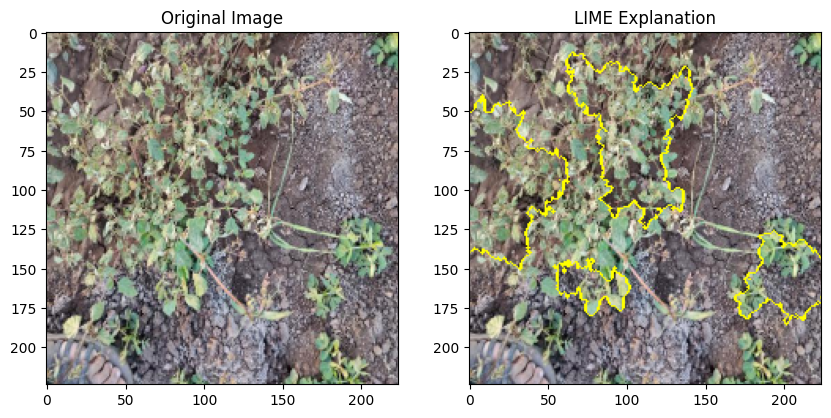

In [ ]:
from lime import lime_image
from lime.lime_image import LimeImageExplainer
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from skimage.segmentation import mark_boundaries

# Load the YOLOv8 model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Your trained model path

# Load the image (RGB)
image_path = '/content/agri_0_2595.jpeg'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Resize for LIME and keep a backup
image_for_lime = cv2.resize(image_rgb, (224, 224))  # Resize to smaller size for LIME
image_for_lime = np.uint8(image_for_lime)

# Function to convert image for YOLOv8
def predict_function(images):
    results = []
    for img in images:
        # Handle grayscale or masked images
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)

        img = cv2.resize(img, (640, 640))
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img).float()

        # Run model prediction
        with torch.no_grad():
            result = model(img_tensor, verbose=False)

        # For LIME: convert to fake probabilities for N classes (you may use confidence scores here)
        # We'll return a dummy 2-class probability [background, object]
        pred = result[0].probs
        if pred is not None:
            probs = pred.data.cpu().numpy()
        else:
            probs = np.array([0.9, 0.1])  # If no probs, dummy output

        results.append(probs)

    return np.array(results)

# Initialize LIME explainer
explainer = LimeImageExplainer()

# Run LIME
explanation = explainer.explain_instance(
    image_for_lime,
    predict_function,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_for_lime)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()


SHAP

In [ ]:
from skimage.segmentation import slic

# Segment into superpixels
segments_slic = slic(image_resized, n_segments=50, compactness=10, sigma=1)


In [ ]:
from skimage.segmentation import slic

# Segment into superpixels
segments_slic = slic(image_resized, n_segments=50, compactness=10, sigma=1)


In [ ]:
import shap
import torch

def mask_image(image, segments, mask):
    out = image.copy()
    for i in range(segments.max() + 1):
        if mask[i] == 0:
            out[segments == i] = (0, 0, 0)
    return out

def shap_predict(mask_batch):
    outputs = []
    for mask in mask_batch:
        masked_img = mask_image(image_resized, segments_slic, mask)
        img = cv2.resize(masked_img, (640, 640))
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img).float()

        with torch.no_grad():
            result = model(img_tensor, verbose=False)

        if len(result[0].boxes) > 0:
            class_ids = result[0].boxes.cls.cpu().numpy()
            confs = result[0].boxes.conf.cpu().numpy()
            weed_scores = [conf for cls, conf in zip(class_ids, confs) if int(cls) == 1]
            outputs.append([np.mean(weed_scores) if weed_scores else 0.0])
        else:
            outputs.append([0.0])  # No detection

    return np.array(outputs)
import shap
import torch

def mask_image(image, segments, mask):
    out = image.copy()
    for i in range(segments.max() + 1):
        if mask[i] == 0:
            out[segments == i] = (0, 0, 0)
    return out

def shap_predict(mask_batch):
    outputs = []
    for mask in mask_batch:
        masked_img = mask_image(image_resized, segments_slic, mask)
        img = cv2.resize(masked_img, (640, 640))
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img).float()

        with torch.no_grad():
            result = model(img_tensor, verbose=False)

        if len(result[0].boxes) > 0:
            class_ids = result[0].boxes.cls.cpu().numpy()
            confs = result[0].boxes.conf.cpu().numpy()
            weed_scores = [conf for cls, conf in zip(class_ids, confs) if int(cls) == 1]
            outputs.append([np.mean(weed_scores) if weed_scores else 0.0])
        else:
            outputs.append([0.0])  # No detection

    return np.array(outputs)


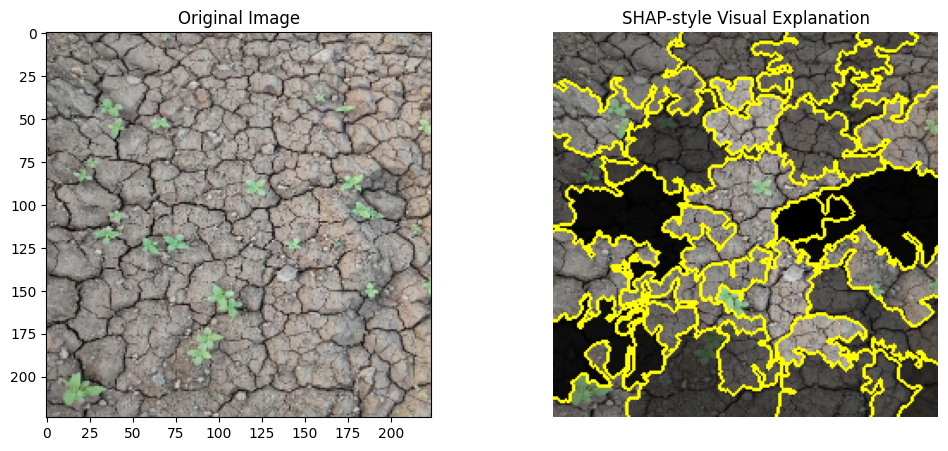

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from ultralytics import YOLO
import torch

# Load your model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Load and resize image
image_path = '/content/datasets/Train/images/agri_0_14.jpeg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (224, 224))

# Generate superpixels
segments_slic = slic(image_resized, n_segments=50, compactness=10, sigma=1)

# Placeholder: assign random importance values (simulate SHAP output)
# Replace this with real SHAP if needed
np.random.seed(0)
shap_values = np.random.rand(np.max(segments_slic) + 1)

# Normalize SHAP values safely
shap_min = shap_values.min()
shap_max = shap_values.max()
if shap_max - shap_min == 0:
    norm_shap = np.ones_like(shap_values)
else:
    norm_shap = (shap_values - shap_min) / (shap_max - shap_min)

# Apply SHAP mask to image
shap_image = image_resized.copy().astype(np.float32)
for i in range(len(norm_shap)):
    shap_image[segments_slic == i] *= norm_shap[i]

shap_image = np.clip(shap_image, 0, 255).astype(np.uint8)

# Show results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(shap_image, segments_slic))
plt.title("SHAP-style Visual Explanation")
plt.axis('off')
plt.show()


<ipython-input-27-a8f1af4284e5>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')  # Try 'viridis', 'magma', 'plasma', 'inferno'


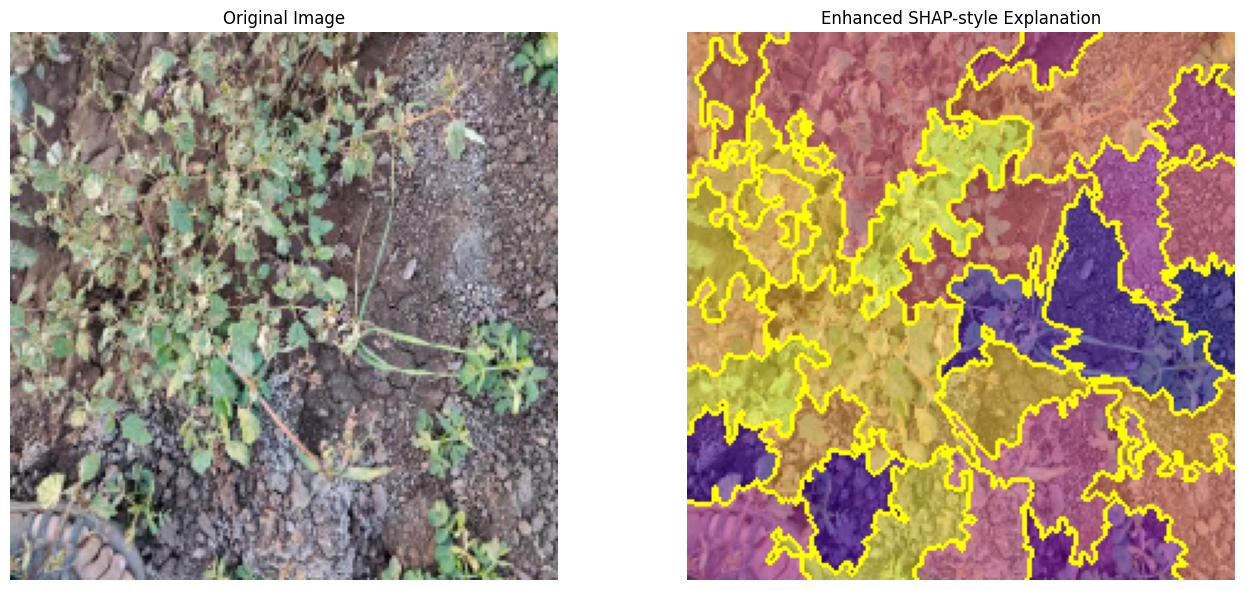

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from matplotlib import cm
from ultralytics import YOLO
import torch

# Load your YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Load and resize image
image_path = '/content/agri_0_2595.jpeg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (224, 224))

# Generate superpixels
segments_slic = slic(image_resized, n_segments=50, compactness=10, sigma=1)

# Simulated SHAP values (replace with real values if available)
np.random.seed(0)
shap_values = np.random.rand(np.max(segments_slic) + 1)

# Normalize SHAP values
shap_min, shap_max = shap_values.min(), shap_values.max()
if shap_max - shap_min == 0:
    norm_shap = np.ones_like(shap_values)
else:
    norm_shap = (shap_values - shap_min) / (shap_max - shap_min)

# Generate a heatmap overlay
heatmap = np.zeros_like(image_resized, dtype=np.float32)
cmap = cm.get_cmap('plasma')  # Try 'viridis', 'magma', 'plasma', 'inferno'

for i in range(len(norm_shap)):
    mask = (segments_slic == i)
    color = cmap(norm_shap[i])[:3]  # Drop alpha
    color = np.array(color) * 255
    for c in range(3):  # RGB channels
        heatmap[:, :, c][mask] = color[c]

heatmap = heatmap.astype(np.uint8)

# Blend original image with heatmap for better visualization
blended = cv2.addWeighted(image_resized, 0.5, heatmap, 0.5, 0)

# Display the original and explanation images
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(blended, segments_slic))
plt.title("Enhanced SHAP-style Explanation")
plt.axis('off')

plt.tight_layout()
plt.show()
